In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import image_helper as ih
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

Считываем все данные из файлов. Получаем словарь {'Название файла': {цвет:процент,цвет:процент}}. Предполагается что файлы с флагами находятся в папке Flags

In [2]:
fileDics = ih.GetFileDics()

/content/image_helper.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  totalPixels = np.array(internalDic)[:,0].sum()


Отбираем коды уникальных цветов (27), формируем матрицу признаков - Х. Заполняем по аналогии с OneHotEncoding. Если в экземпляре присутствует цвет - проставляем процент, который присутствует (в сотых долях - как считалось). Если цвет не присутствует - оставляем 0. Создаем и настраиваем алгоритм кластеризации

In [3]:
colors = set()
for fc in fileDics.values():
  for c in fc.keys():  
    colors.add(c)
print("Кол-во цветов:", len(colors))

colors=list(colors)
colors.sort()

X=list()
y=list()
fccopy=list()

for fc in fileDics.values():
  fccopy=list() 
  for c in colors:
    if fc.get(c) == None:
      fccopy.append(0) 
    else:
      fccopy.append(fc[c])
  X.append(fccopy)
  fccopy=[]

for f in fileDics:
  y.append(f)

print(X)
print(y)

Кол-во цветов: 27
[[0, 0.7711111111111111, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.08185185185185186, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.08518518518518518], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3333333333333333, 0, 0.3333333333333333, 0, 0.3333333333333333], [0, 0.26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.4648], [0, 0, 0, 0.20137724550898203, 0, 0.21694610778443113, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.15419161676646706, 0, 0, 0, 0, 0, 0, 0, 0.21694610778443113, 0, 0.17766467065868263], [0, 0, 0, 0.4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3, 0, 0, 0.3, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0.33, 0, 0, 0, 0, 0, 0, 0, 0, 0.3795726495726496, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.26153846153846155], [0, 0, 0, 0, 0, 0.33, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.33, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.32], [0, 0.3333333333333333, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3333333333333333, 0.3333333333333333, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0

Выбираем количество кластеров методом локтя

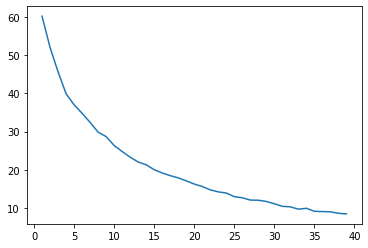

In [4]:
from sklearn.cluster import KMeans, DBSCAN
inertia = [KMeans(n_clusters=i).fit(X).inertia_ for i in range(1,40)]
plt.plot(range(1,40),inertia)
plt.show()

По графику видно, что выбирать количество меньше 5 точно не стоит, потому что до 5 идет резкий спад. Брать ближе к 10 нецелесообразно, так что выбор пал на 8

In [5]:
from sklearn.cluster import KMeans, DBSCAN
clustering = KMeans(n_clusters=8, init='k-means++')
y_kmeans = clustering.fit_predict(X)

Отображаем получившиеся группы. Для DBSCAN группы groupId начинаются от -1 (группа, в которую попали все неотобранные флаги - шумовые точки) до max+2. Для KMeans от 0 до max+1

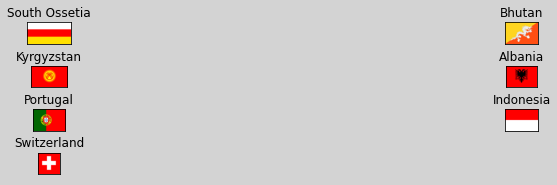

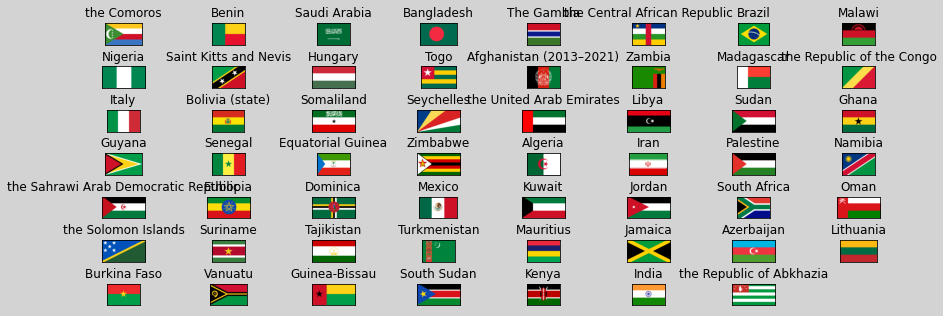

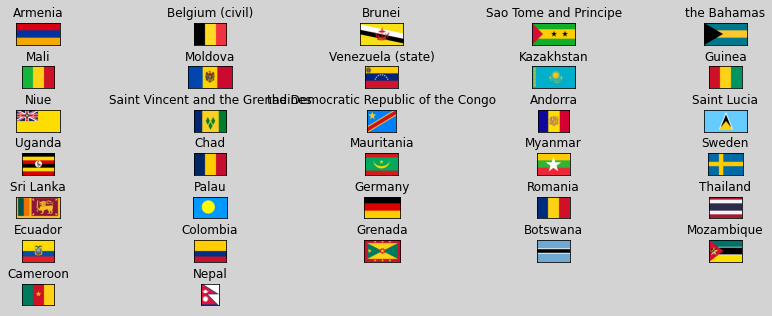

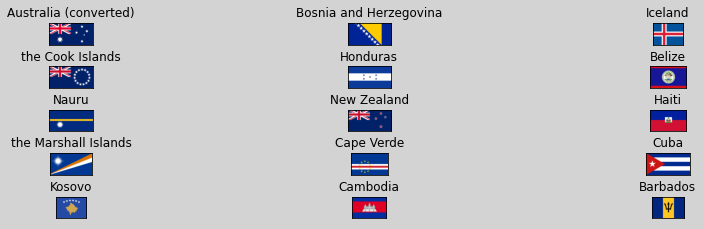

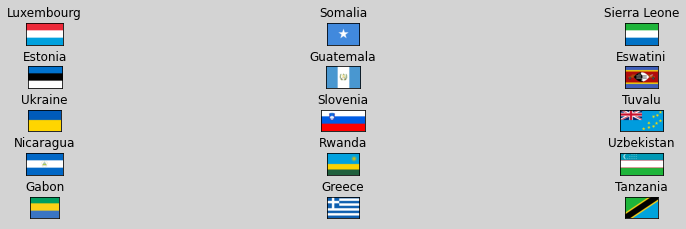

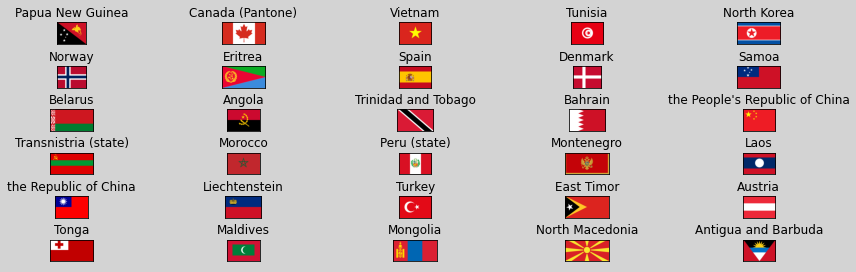

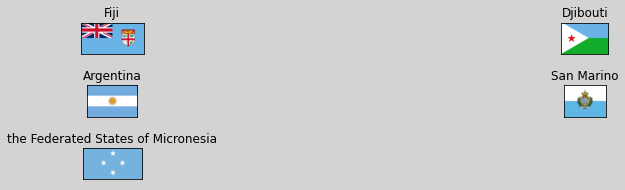

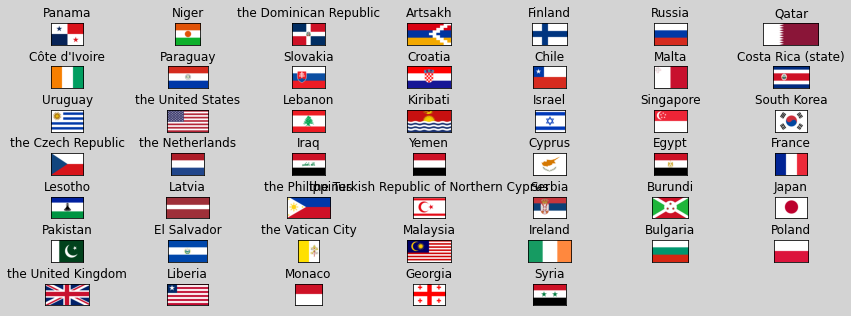

In [6]:
for groupId in range(0, max(clustering.labels_)+1):
    group = np.array(list(fileDics.keys()))[clustering.labels_ == groupId]
    ih.PrintGroup(group)

<b>Выводы:</b> метод k-средних преимущественно хорошо разбил флаги на кластеры по цветам, но все-таки есть погрешность (или какие-то другие критерии отбора)

Шум: 70
Кластеров: 11


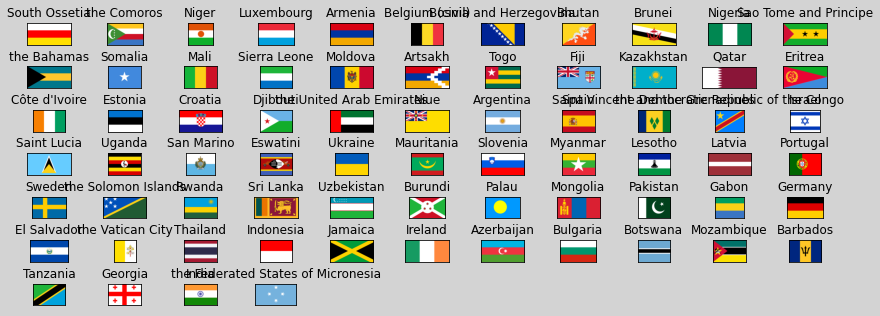

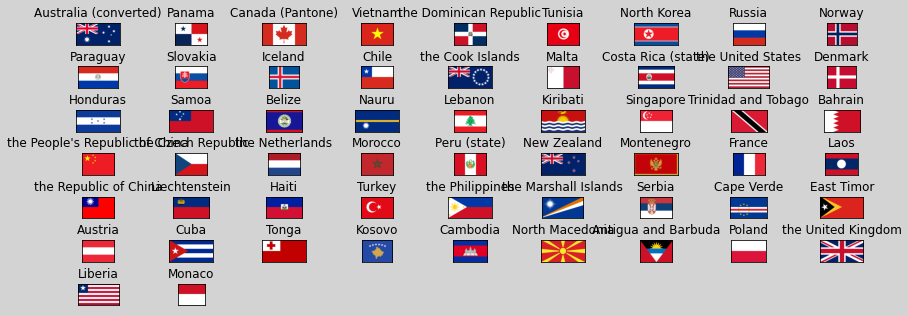

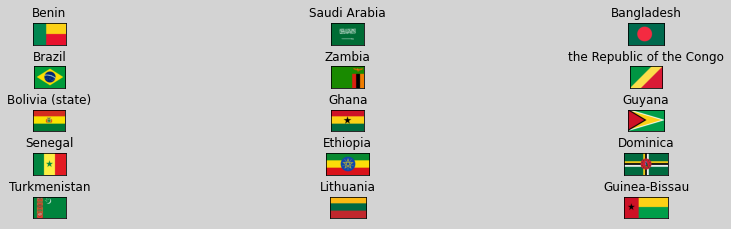

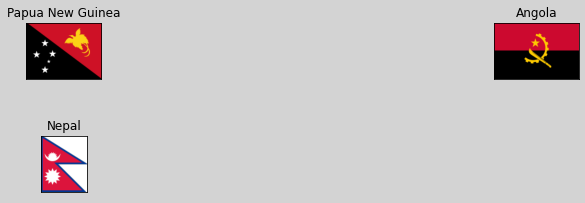

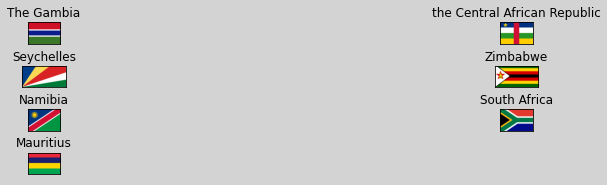

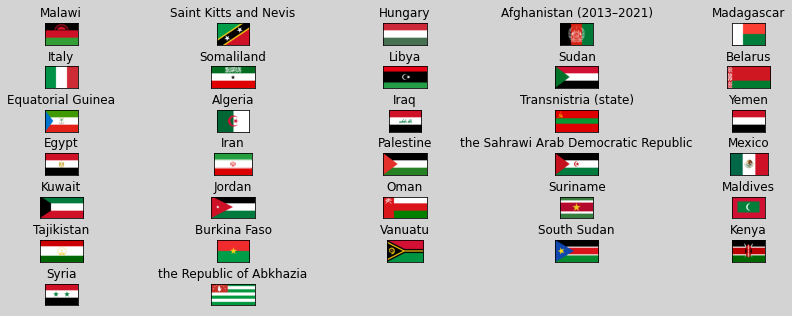

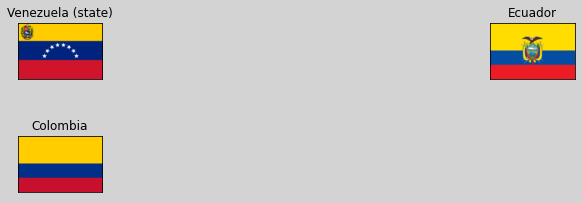

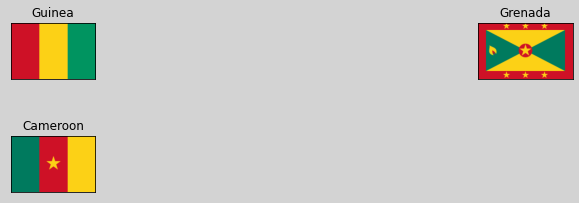

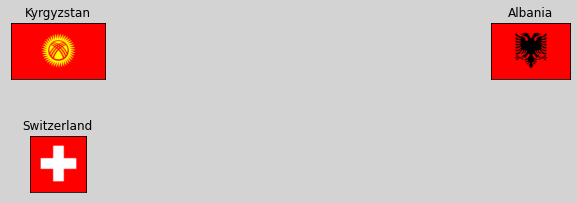

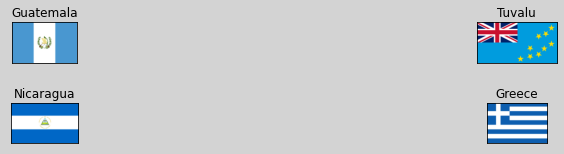

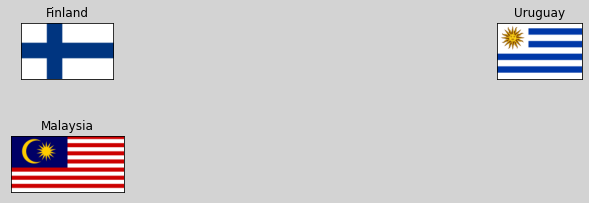

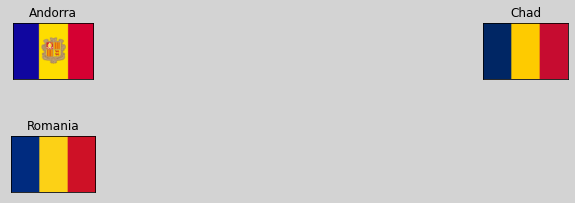

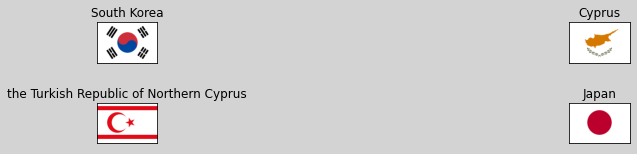

<Figure size 432x288 with 0 Axes>

In [8]:
clustering = DBSCAN(eps=0.25384615384615383, min_samples=3).fit(X)
y_kmeans = clustering.fit_predict(X)
print("Шум:", sum(clustering.labels_==-1))
print("Кластеров:", max(clustering.labels_))
for groupId in range(-1, max(clustering.labels_)+2):
    group = np.array(list(fileDics.keys()))[clustering.labels_ == groupId]
    ih.PrintGroup(group)

Построим вспомогательный график расстояний между точками и будем смотреть значения кривизны графика для выбора наилучшего параметра epsilon. По нему главные всплески начинаются на 1.5 заканчиваются примерно на 5

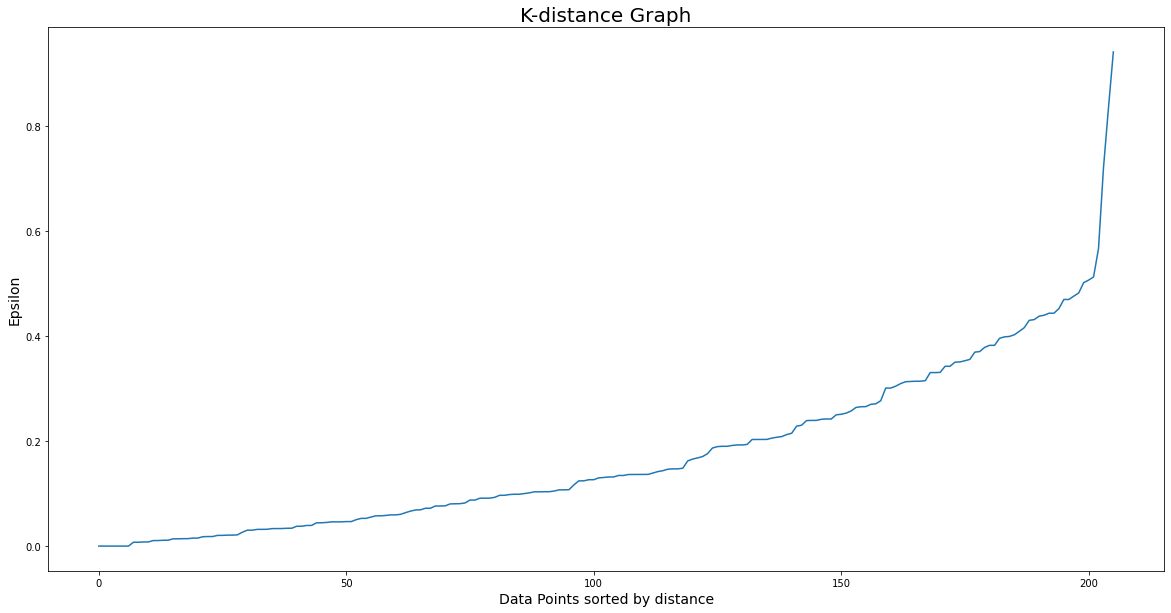

In [9]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors = 2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

# Отобразим график расстояний между точками
distances = np.sort(distances, axis = 0)
distances = distances[:, 1]
plt.figure(figsize = (20, 10))
plt.plot(distances)
plt.title('K-distance Graph', fontsize = 20)
plt.xlabel('Data Points sorted by distance', fontsize = 14)
plt.ylabel('Epsilon', fontsize = 14)
plt.show()

**Вывод:** Путем перебора было обнаружено, что наилучший результат и разбиение флагов на кластеры достигается при минимальном наборе в кластере = 2. Иначе количество "шума", флагов, которые не вошли ни в какой кластер (-1), существенно увеличивалось.
По поводу выбора области epsilon. Из промежутка с наибольшей кривизной было выбрано наименьшее значение как начальное при выборе параметров. Почему: чем больше будет расстояние, тем менее вероятность того, что алгоритм DSCAN будет отбирать кластеры по цвету, а не по чему-то другому (imho). Потому что при подборе встречались случаи, когда он как будто определял в один кластер флаги по количеству цветов в флаге, а не по тому, какие это цвета.
При выборе наилучших параметров использовался ориентир на количество "шума" и количество кластеров, а также визуально оценивалась "адекватность" распределения, грубо говоря действительно ли флаги образовывали кластеры с похожим соотношением цветов.
Часть истории подбора параметров, где |eps min_samples noise (clusters)|:

1. |0.12  2 109  |
2. |0.14  2 93   | 
3. |0.145 2 91   | 
4. |0.16  2 87   | 
5. |0.18  2 82   | 
6. |0.19  2 78   |  
7. |0.28  2 47 14| 
8. |0.25  2 56 20|


Также было замечено, что алгоритм DBSCAN гораздо точнее разделяет на кластеры в основном, чем k-means, если не считать шум. Но он требует более точного подбора параметров (зато сам определяет число кластеров), в то время для k-means нужно самому заранее определить оптимальное число кластеров, что как показалось в ходе работы, значительно легче подбора параметров для метода, основанного на плотности.

In [15]:
c = np.linspace(0.15,0.38,800)

param_grid = [{"min_samples": [2,3,4],
             "eps": c}]

def my_scorer_dbscan(estimator, X, y=None):
    estimator.fit(X)
    return -1 * np.count_nonzero(estimator.labels_ == -1) + 25*max(estimator.labels_)


clustering = DBSCAN()

grid_search = GridSearchCV(clustering, param_grid, cv=3, scoring=my_scorer_dbscan)
grid_search.fit(X)
print("Лучшие параметры : " + str(grid_search.best_params_))

Лучшие параметры : {'eps': 0.25823529411764706, 'min_samples': 2}


Шум: 53
Кластеров: 19


/content/image_helper.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axarr = plt.subplots(min(len(names),rows),max(2,width), facecolor='lightgray') #sharex=True, sharey=True,


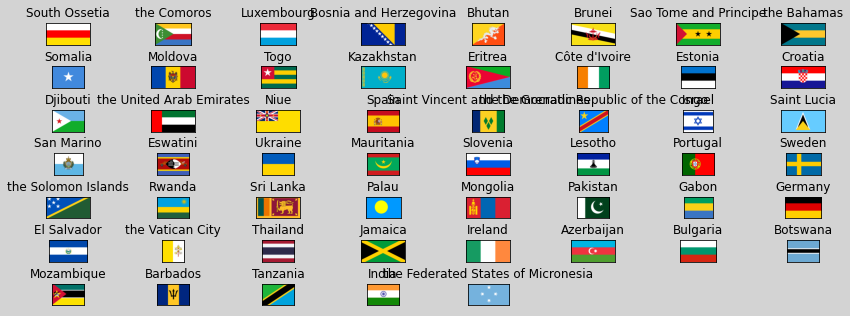

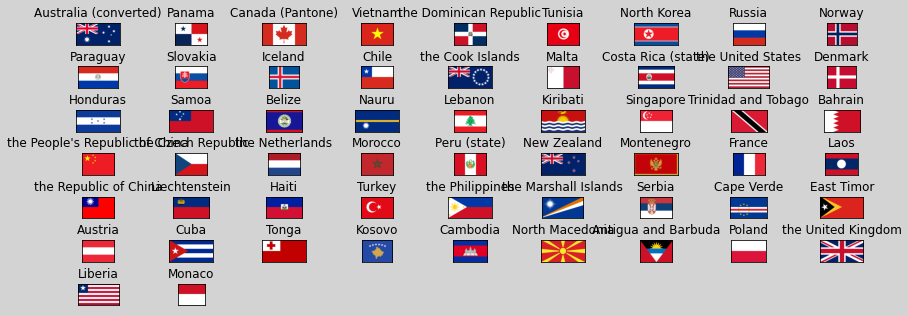

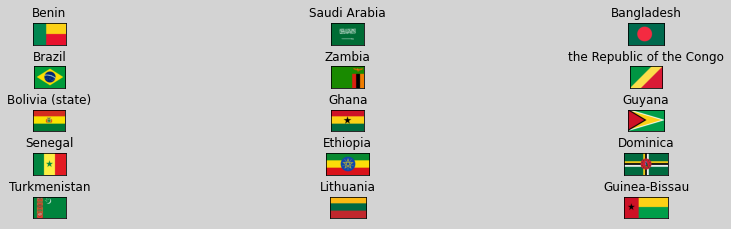

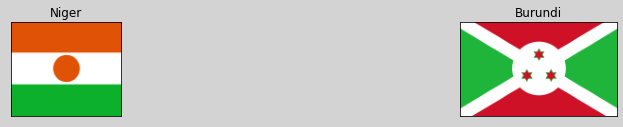

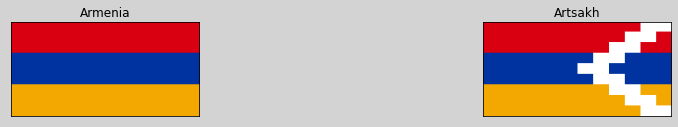

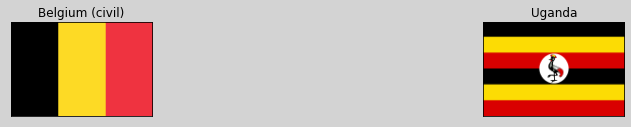

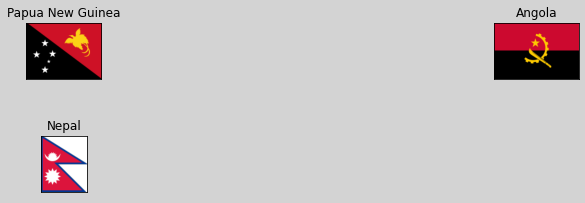

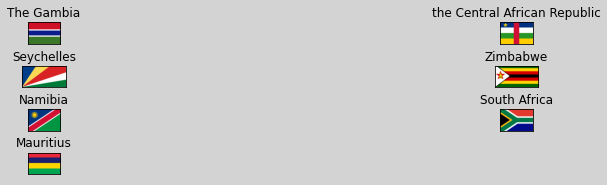

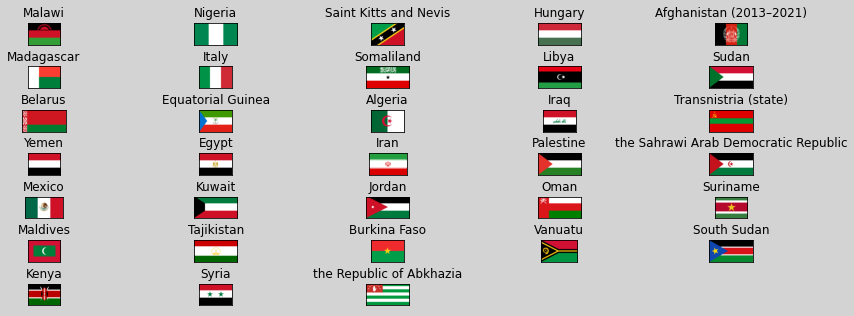

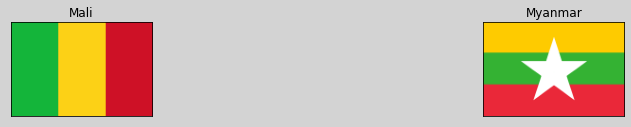

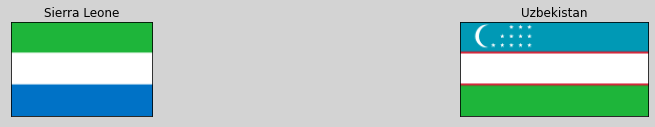

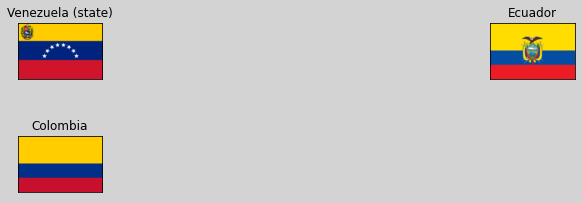

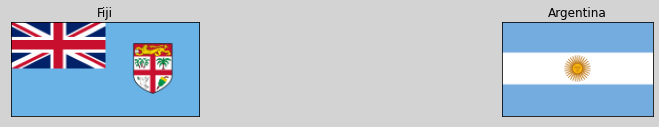

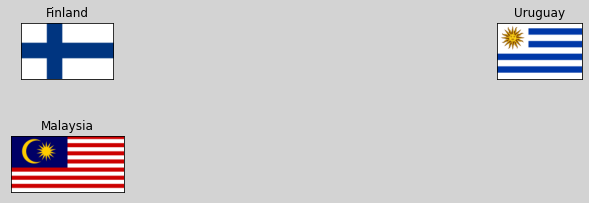

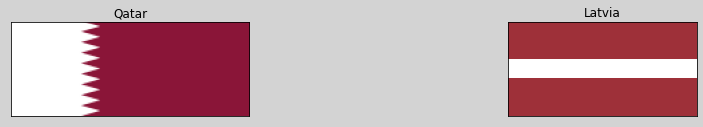

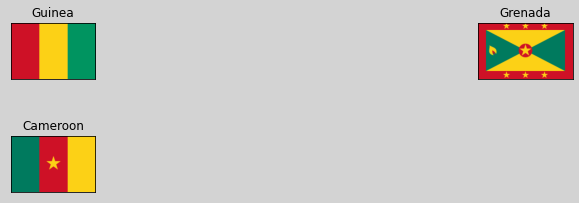

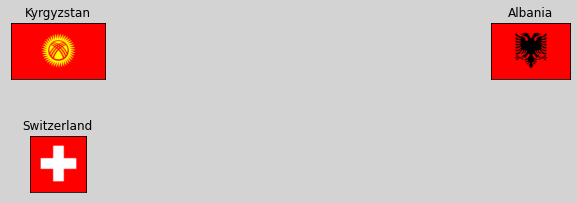

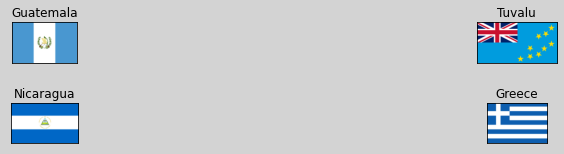

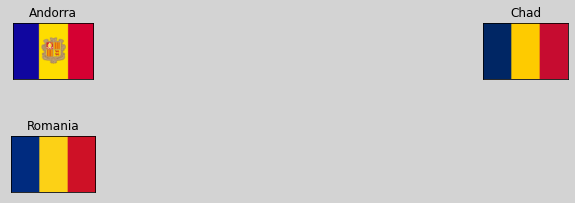

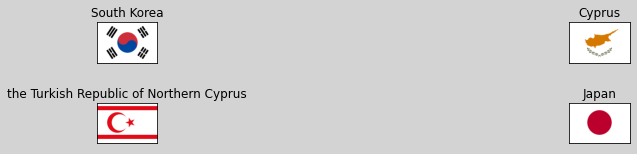

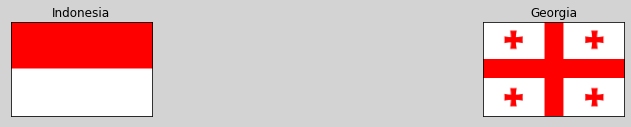

<Figure size 432x288 with 0 Axes>

In [13]:
clustering = DBSCAN(eps=0.2581162324649299, min_samples=2).fit(X)
y_kmeans = clustering.fit_predict(X)
print("Шум:", sum(clustering.labels_==-1))
print("Кластеров:", max(clustering.labels_))
for groupId in range(-1, max(clustering.labels_)+2):
    group = np.array(list(fileDics.keys()))[clustering.labels_ == groupId]
    ih.PrintGroup(group)

Получилось неплохо:
Лучшие параметры : {'eps': 0.2581162324649299, 'min_samples': 2}

При любом раскладе если рассматривать такой пул параметров 
```
c = np.linspace(0.1,0.4,800)
param_grid = [{"min_samples": [2,3,4],
             "eps": c}]
```

будет один результат - ~0.258 и 2